In [1]:
import numpy as np
import torch
from pathlib import Path
from noise2inverse import tiffs, noise, fig
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
import tomosipo as ts
import tomopy
import tifffile
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# Parameters
input_dir = Path("reconstructions")
weights_path = Path("weights/weights.torch")
output_dir = Path("denoised")

num_splits = 4
strategy = "X:1"
batch_size = num_splits
multi_gpu = True
# Scale pixel intensities in the same way as during training.
data_scaling = 200

In [19]:
# Output dir
output_dir.mkdir(exist_ok=True)

In [20]:
datasets = [TiffDataset(input_dir / f"{j}/*.tif") for j in range(num_splits)]
ds = Noise2InverseDataset(*datasets, strategy=strategy)

In [21]:
# Dataloader and network:
dl = DataLoader(ds, batch_size, shuffle=False,)
model = MSDRegressionModel(1, 1, 100, 1,parallel=True)
model.load(weights_path)

24

In [22]:
# Put network in evaluation mode: this should be done when the network uses batch norm for instance.
model.net.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(dl)):
        inp, _ = batch     
        inp = inp.cuda() * data_scaling
        out = model.net(inp)
        # Take mean over batch dimension (splits):
        out = out.mean(dim=0) / data_scaling
        # Obtain 2D numpy array
        out_np = out.detach().cpu().numpy().squeeze()
        out_path = str(output_dir / f"output_{i:05d}.tif")
        tifffile.imsave(out_path, out_np)

512it [02:23,  3.56it/s]


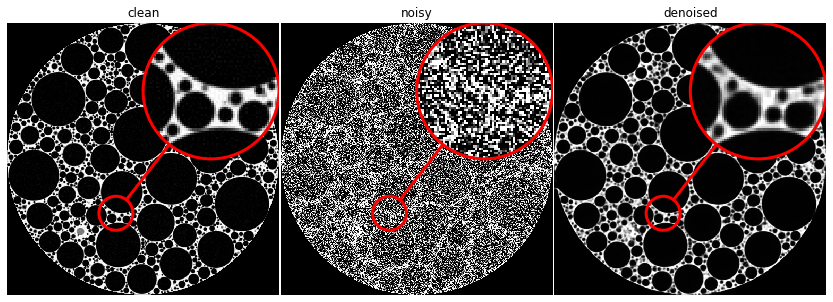

In [24]:
fig.plot_imgs(
    clean=tifffile.imread("./reconstructions/clean/output_00256.tif"),
    noisy=tifffile.imread("./reconstructions/noisy/output_00256.tif"),
    denoised=tifffile.imread("./denoised/output_00256.tif"),
    vmin=0,
    vmax=0.004,
    width=15,
)
import matplotlib.patches as patches

axes = plt.gcf().axes
for ax in axes[:3]:
    fig.add_zoom_bubble(ax.images[0], roi=(.4, .3), zoom=4, inset_radius=.25)